Name: SARTHAK MISHRA

email: sarthakmishra4000@gmail.com


Ethereum price prediction using Multivariate RNN

Importing libraries

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
tensorflow.random.set_seed(2)

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time

1. Data Preprocessing

We used the historical prices of Ethereum obtained from Binance Exchange. It contains records of hourly prices of Ethereum from 17/08/2017 to 12/06/2021. Each record contains information of opening, high, low, and closing value of Ethereum as well as the volume sold on that day.

In [59]:
# Loading the dataset
url = '/content/ETHUSDT5m.csv'
df = pd.read_csv(url, parse_dates=True, dayfirst=True, index_col = 0)

df.head(),df.tail(),len(df)

(                       open   close    high  ...    volume  noOfTrades
 opentime                                     ...                      
 2017-08-17 04:00:00  301.13  301.13  301.13  ...   3.82951        12.0
 2017-08-17 04:05:00  300.00  298.00  301.13  ...   1.97216        10.0
 2017-08-17 04:10:00  298.00  298.00  298.00  ...   0.00000         0.0
 2017-08-17 04:15:00  298.00  299.05  299.05  ...  12.88486         4.02
 2017-08-17 04:20:00  299.05  300.10  300.10  ...   6.58304         8.0
 
 [5 rows x 6 columns],
                         open    close  ...  noOfTrades
 opentime                               ...            
 2021-06-12 10:10:00  2322.88  2309.69  ...      4900.0
 2021-06-12 10:15:00  2309.63  2315.27  ...      9173.0
 2021-06-12 10:20:00  2315.56  2315.05  ...      4417.0
 2021-06-12 10:25:00  2315.04  2340.90  ...     10567.0
 2021-06-12 10:30:00  2340.50  2374.25  ...     19291.0
 
 [5 rows x 6 columns],
 400630)

Grouping the dataset in chunks of 60 mins

In [60]:
df = df.groupby(pd.Grouper(freq='60Min')).agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum', 'noOfTrades':'sum'})
df.head()

,open,high,low,close,volume,noOfTrades
opentime,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877,129.0
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246,202.0
2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672,182.0
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510,198.0
2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029,182.0


Analyzing the distribution of opening prices of all the time intervals in the entire dataset

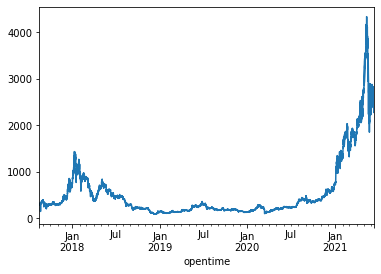

In [61]:
df['open'].plot()

In [62]:
# Correlation matrix
df.corr()['open']

open          1.000000
high          0.999916
low           0.999818
close         0.999814
volume        0.266646
noOfTrades    0.712785
Name: open, dtype: float64

First, we remove some redundant and noisy data, such as the records with volume 0 and scale it from 0-1.



In [63]:
# Distribution of Various Features
print(df.describe().volume) 
df.drop(df[df['volume'] == 0].index, inplace = True)# Dropping rows with volume value 0

count     33487.000000
mean      22557.960335
std       29587.847904
min           0.000000
25%        5320.489500
50%       13276.182510
75%       28686.949995
max      493227.882820
Name: volume, dtype: float64


In [64]:
df['volumen'] = (df['volume'] - df['volume'].min()) / (df['volume'].max() - df['volume'].min())
df['volumen'].describe()

count    33362.000000
mean         0.045907
std          0.060035
min          0.000000
25%          0.010927
50%          0.027083
75%          0.058366
max          1.000000
Name: volumen, dtype: float64

In [67]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=75,  verbose=1, mode='min')

modelSave = ModelCheckpoint(
    "/content/keras/weights-{epoch:02d}.hdf5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
)

In [68]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                        activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))

    model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [69]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_pred)
    return mse, rmse, r, Y_test, Y_pred

In [70]:
# Plotting the predictions
def plot_data(Y_test,Y_pred):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_pred,c = 'y')
    #plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Ethereum Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [71]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

We pick 5 parameters for our model, OHLC candlestick data and the normalised volume.

In [72]:
# Extracting the series
series = df[['open','close','high','low','volumen']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(33362, 5)
                        open    close     high      low   volumen
opentime                                                         
2021-06-12 06:00:00  2290.34  2299.11  2302.00  2283.47  0.044281
2021-06-12 07:00:00  2299.11  2322.12  2325.44  2299.11  0.072277
2021-06-12 08:00:00  2322.12  2308.01  2322.92  2302.05  0.059376
2021-06-12 09:00:00  2308.00  2326.51  2327.37  2301.26  0.057478
2021-06-12 10:00:00  2326.48  2374.25  2389.00  2297.10  0.103863


This data was split into train, validation and test data. The training data contains records from 17 Aug 2017 to 30 Apr 2021, validation data contains records from 1 May 2021 to 31 May 2021 and test data contains records from 1 Jun 2021 to 12 Jun 2021.

In [73]:
# Train Val Test Split
train_start = dt.date(2017,8,17)
train_end = dt.datetime(2021,4,30,23)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2021,5,1)
val_end = dt.datetime(2021,5,31,23)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2021,6,1)
test_end = dt.datetime(2021,6,12,23)
test_data = series.loc[test_start:test_end]

(train_data.shape,val_data.shape,test_data.shape)

((32343, 5), (744, 5), (275, 5))

In [74]:
train = np.array(train_data)
val = np.array(val_data)
test = np.array(test_data)
print(train.shape,val.shape,test.shape)

(32343, 5) (744, 5) (275, 5)


In [75]:
# Hyperparameters
timesteps = 24
hl = [50,45]
lr = 0.001
batch_size = 32
num_epochs = 200

Epoch 1/200
1010/1010 [==============================] - 18s 16ms/step - loss: 1854.2936 - val_loss: 143598.1406
Epoch 2/200
1010/1010 [==============================] - 15s 15ms/step - loss: 813.2502 - val_loss: 61496.8438
Epoch 3/200
1010/1010 [==============================] - 15s 15ms/step - loss: 719.6935 - val_loss: 57060.9766
Epoch 4/200
1010/1010 [==============================] - 15s 15ms/step - loss: 423.7549 - val_loss: 30528.2500
Epoch 5/200
1010/1010 [==============================] - 15s 15ms/step - loss: 467.7931 - val_loss: 45557.9570
Epoch 6/200
1010/1010 [==============================] - 15s 15ms/step - loss: 345.1493 - val_loss: 32083.1562
Epoch 7/200
1010/1010 [==============================] - 15s 15ms/step - loss: 280.5348 - val_loss: 22195.2383
Epoch 8/200
1010/1010 [==============================] - 15s 15ms/step - loss: 214.7250 - val_loss: 5864.6377
Epoch 9/200
1010/1010 [==============================] - 15s 15ms/step - loss: 191.3231 - val_loss: 19189.0723


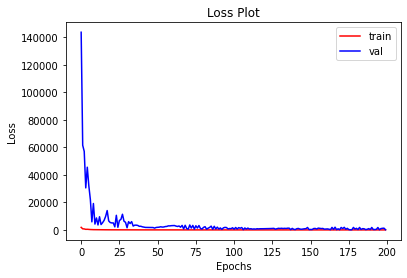

In [76]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

In [77]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 24, 5)             55        
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 24, 50)            2800      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 45)                4320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 46        
Total params: 7,221
Trainable params: 7,221
Non-trainable params: 0
_________________________________________________________________


Applying the model on the testing data

ETH Price prediction
MSE = 38.8054952229149
RMSE = 6.229405687777518
R-Squared Score = 0.9980708654392528


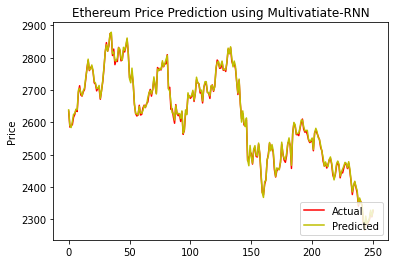

In [78]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("ETH Price prediction")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [79]:
# Saving the model for future use
model.save('MV5-BTC1h_RNN_24_[50,45]_1e-3_32.hdf5') #local
model.save('/content/drive/MyDrive/Saved models/MV5-BTC1h_RNN_24_[50,45]_1e-3_32.hdf5') #drive
print('Model saved!')

Model saved!


In [80]:
# Delete model
del model